In [1]:
from PIL import Image
from tqdm import tqdm
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize

#이미지 불러오기

train_path = 'C:/MLDL/crop_train_result/granulation/'
mask_path = 'C:/MLDL/crop_train_mask_result/granulation/'

train_list = os.listdir(train_path)
mask_list = os.listdir(mask_path)
#X를 uint8로 해야하나
X = np.zeros((len(train_list), 31,31, 3), dtype=np.uint8)
Y = np.zeros((len(mask_list), 31,31, 1), dtype=np.bool)

for n, name in tqdm(enumerate(train_list), total=len(train_list)):
    path = train_path + name
    img = imread(path)
    img = resize(img, output_shape=(31,31,3), preserve_range=True)
    X[n]=np.array(img)

for n, maskname in tqdm(enumerate(mask_list), total = len(mask_list)):
#for n, maskname in enumerate(mask_list):
    path = mask_path + maskname
    mask=imread(path,as_gray=True)
    mask = resize(mask, output_shape=(31,31,1), preserve_range=True)
    Y[n] = np.array(mask)
    
    
    
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1)
savepath='C:/MLDL/npy/granulation/'
np.save(savepath+'x_train_granulation', x_train)
np.save(savepath+'y_train_granulation', y_train)
np.save(savepath+'x_val_granulation', x_val)
np.save(savepath+'y_val_granulation', y_val)

100%|███████████████████████████████████████████████████████████████████████████████| 880/880 [00:03<00:00, 237.33it/s]


In [2]:
import numpy as np
x_train=np.load('C:/MLDL/npy/granulation/x_train_granulation.npy')/255.
y_train=np.load('C:/MLDL/npy/granulation/y_train_granulation.npy')
x_val=np.load('C:/MLDL/npy/granulation/x_val_granulation.npy')/255.
y_val=np.load('C:/MLDL/npy/granulation/y_val_granulation.npy')


In [3]:
print(x_train.shape)

(792, 31, 31, 3)


In [4]:
#sigmoid
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (5,5),strides=(2,2), activation='relu', input_shape=(31, 31, 3)), 
    tf.keras.layers.Conv2D(32, (5, 5), strides=(2,2),activation='relu'),
    tf.keras.layers.Conv2D(64,(5, 5),strides=(2,2), activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, (5, 5),strides=(2,2)),
    tf.keras.layers.Conv2DTranspose(32, (6, 6),strides=(2,2)),
    tf.keras.layers.Conv2DTranspose(16, (5, 5),strides=(2,2)),
    tf.keras.layers.Conv2D(1, 1,strides=1,activation='sigmoid')
                

])

model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          12832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 64)          51264     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 64)          102464    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 32)        73760     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 31, 31, 16)        12816     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 1)         1

In [5]:
model.compile(optimizer='adam' #decay0.0001, momentum 0.9?
              , loss='binary_crossentropy'
              , metrics=[tf.keras.metrics.MeanIoU(num_classes=2), 'accuracy'])

In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
callback_param = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='auto', min_lr=1e-05)

history = model.fit(x_train, y_train
                    , validation_data=(x_val, y_val)
                    , epochs=100, batch_size=100
                    , callbacks=[callback_param]
                    )

Epoch 1/100
8/8 [==============================] - 2s 234ms/step - loss: 0.6772 - mean_io_u: 0.3172 - accuracy: 0.6133 - val_loss: 0.6262 - val_mean_io_u: 0.3513 - val_accuracy: 0.7027
Epoch 2/100
8/8 [==============================] - 1s 171ms/step - loss: 0.6494 - mean_io_u: 0.3172 - accuracy: 0.6343 - val_loss: 0.6031 - val_mean_io_u: 0.3513 - val_accuracy: 0.7024
Epoch 3/100
8/8 [==============================] - 2s 290ms/step - loss: 0.6147 - mean_io_u: 0.3172 - accuracy: 0.6352 - val_loss: 0.5477 - val_mean_io_u: 0.3513 - val_accuracy: 0.7288
Epoch 4/100
8/8 [==============================] - 2s 285ms/step - loss: 0.5511 - mean_io_u: 0.3172 - accuracy: 0.7117 - val_loss: 0.5866 - val_mean_io_u: 0.3513 - val_accuracy: 0.6949
Epoch 5/100
8/8 [==============================] - 2s 226ms/step - loss: 0.5159 - mean_io_u: 0.3172 - accuracy: 0.7510 - val_loss: 0.4718 - val_mean_io_u: 0.3513 - val_accuracy: 0.7938
Epoch 6/100
8/8 [==============================] - 2s 192ms/step - loss: 0.

8/8 [==============================] - ETA: 0s - loss: 0.1857 - mean_io_u: 0.3549 - accuracy: 0.9293
Epoch 00042: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
8/8 [==============================] - 2s 199ms/step - loss: 0.1857 - mean_io_u: 0.3549 - accuracy: 0.9293 - val_loss: 0.4487 - val_mean_io_u: 0.3694 - val_accuracy: 0.8422
Epoch 43/100
8/8 [==============================] - 2s 282ms/step - loss: 0.1827 - mean_io_u: 0.3555 - accuracy: 0.9294 - val_loss: 0.4395 - val_mean_io_u: 0.3692 - val_accuracy: 0.8481
Epoch 44/100
8/8 [==============================] - 2s 244ms/step - loss: 0.1813 - mean_io_u: 0.3557 - accuracy: 0.9314 - val_loss: 0.4467 - val_mean_io_u: 0.3700 - val_accuracy: 0.8432
Epoch 45/100
8/8 [==============================] - 2s 262ms/step - loss: 0.1801 - mean_io_u: 0.3578 - accuracy: 0.9317 - val_loss: 0.4399 - val_mean_io_u: 0.3697 - val_accuracy: 0.8515
Epoch 46/100
8/8 [==============================] - 2s 253ms/step - loss: 0.1791 - mean_i

8/8 [==============================] - 2s 294ms/step - loss: 0.1649 - mean_io_u: 0.3675 - accuracy: 0.9375 - val_loss: 0.4691 - val_mean_io_u: 0.3750 - val_accuracy: 0.8469
Epoch 83/100
8/8 [==============================] - 1s 182ms/step - loss: 0.1646 - mean_io_u: 0.3677 - accuracy: 0.9374 - val_loss: 0.4698 - val_mean_io_u: 0.3751 - val_accuracy: 0.8467
Epoch 84/100
8/8 [==============================] - 2s 252ms/step - loss: 0.1645 - mean_io_u: 0.3677 - accuracy: 0.9376 - val_loss: 0.4701 - val_mean_io_u: 0.3750 - val_accuracy: 0.8466
Epoch 85/100
8/8 [==============================] - 2s 194ms/step - loss: 0.1642 - mean_io_u: 0.3680 - accuracy: 0.9378 - val_loss: 0.4705 - val_mean_io_u: 0.3751 - val_accuracy: 0.8467
Epoch 86/100
8/8 [==============================] - 2s 217ms/step - loss: 0.1641 - mean_io_u: 0.3679 - accuracy: 0.9380 - val_loss: 0.4693 - val_mean_io_u: 0.3750 - val_accuracy: 0.8478
Epoch 87/100
8/8 [==============================] - 2s 278ms/step - loss: 0.1639 - 

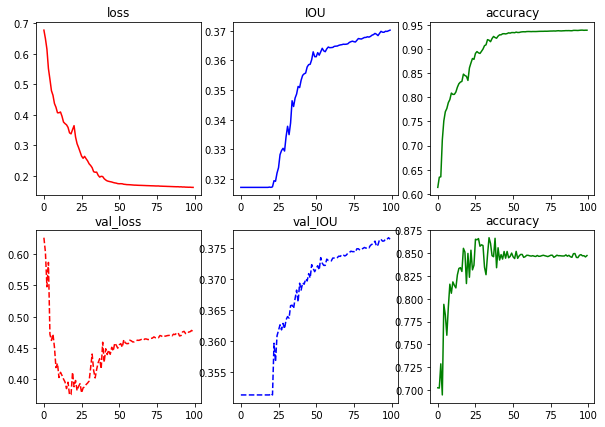

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('IOU')
ax[0, 1].plot(history.history['mean_io_u'], 'b')
ax[0, 2].set_title('accuracy')
ax[0, 2].plot(history.history['accuracy'], 'g')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_IOU')
ax[1, 1].plot(history.history['val_mean_io_u'], 'b--')
ax[1, 2].set_title('accuracy')
ax[1, 2].plot(history.history['val_accuracy'], 'g')

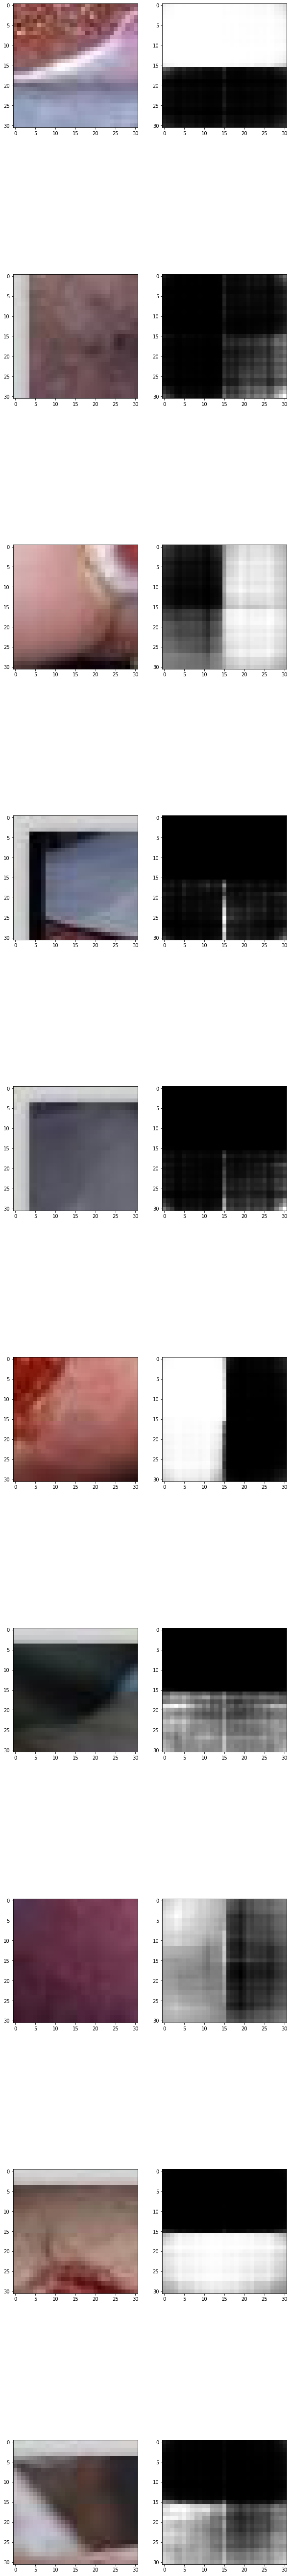

In [8]:
preds_val = model.predict(x_val[:10])

fig, ax = plt.subplots(len(preds_val), 2, figsize=(10, 100))

for i, pred in enumerate(preds_val):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    #ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(pred.squeeze(), cmap='gray')

In [11]:


#이미지 불러오기

test_path = 'C:/MLDL/crop_test_result/granulation/'
testmask_path = 'C:/MLDL/crop_test_mask_result/granulation/'
test_list = os.listdir(test_path)
testmask_list = os.listdir(testmask_path)
#X를 uint8로 해야하나
X = np.zeros((len(test_list), 31,31, 3), dtype=np.uint8)
Y = np.zeros((len(testmask_list), 31,31, 1), dtype=np.bool)

for n, name in tqdm(enumerate(test_list), total=len(test_list)):
    path = test_path + name
    img = imread(path)
    img = resize(img, output_shape=(31,31,3), preserve_range=True)
    X[n]=np.array(img)

for n, maskname in tqdm(enumerate(testmask_list), total = len(testmask_list)):
#for n, maskname in enumerate(mask_list):
    path = testmask_path + maskname
    mask=imread(path,as_gray=True)
    mask = resize(mask, output_shape=(31,31,1), preserve_range=True)
    Y[n] = np.array(mask)
    
    

savepath='C:/MLDL/npy_test/granulation/'
np.save(savepath+'x_test_granulation', X)
np.save(savepath+'y_test_granulation', Y)

100%|█████████████████████████████████████████████████████████████████████████████| 3762/3762 [00:18<00:00, 200.11it/s]


In [13]:
import numpy as np
x_test_granulation=np.load('C:/MLDL/npy_test/granulation/x_test_granulation.npy')/255.
y_test_granulation=np.load('C:/MLDL/npy_test/granulation/y_test_granulation.npy')


In [14]:
evaluation = model.evaluate(x_test_granulation,y_test_granulation, batch_size=10)

377/377 [==============================] - 5s 13ms/step - loss: 0.8418 - mean_io_u: 0.4093 - accuracy: 0.7606


In [15]:
preds = model.predict(x_test_granulation)
preds[preds>=0.5] = 1
preds[preds<0.5]=0

(array([  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        , 100.00000224,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.

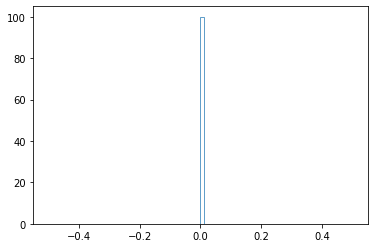

In [16]:
#prediction 값 분포를 보고 threshold 정하기
plt.hist(np.ravel(preds[0], order='C'), bins=100, density=True, alpha=0.7, histtype='step')

In [17]:
m=tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(y_test_granulation,preds)
print(m.result())

tf.Tensor(0.5549547, shape=(), dtype=float32)


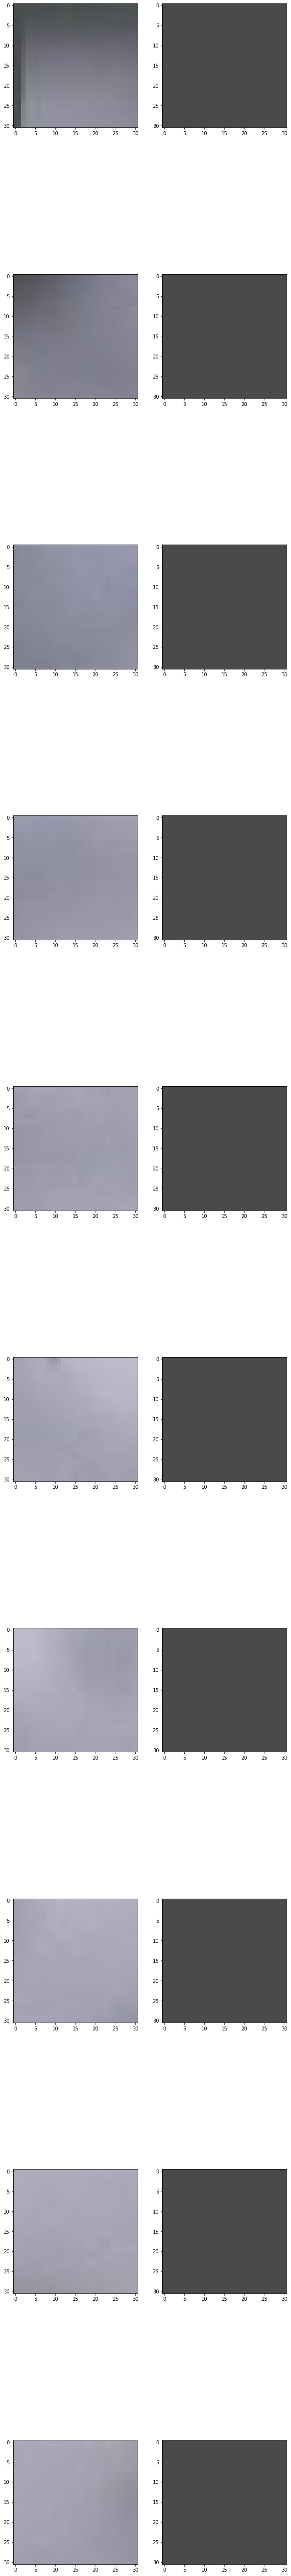

In [19]:
kernel = np.ones((5,5),np.uint8)
fig, ax = plt.subplots(len(x_test_granulation[0:10]), 2, figsize=(10, 100))

for i, pred in enumerate(preds[0:10]):
    ax[i, 0].imshow(x_test_granulation[i].squeeze(), cmap='gray')
    ax[i, 0].imshow(pred.squeeze(), cmap='Blues', alpha=0.3)
    ax[i, 1].imshow(y_test_granulation[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(pred.squeeze(), cmap='Blues', alpha=0.3)
  

In [ ]:
import numpy as np
x=np.load('C:/Users/박신영/Desktop/2학기/머신러닝과 딥러닝/프로젝트 논문/npy1106/X.npy')/255.
y=np.load('C:/Users/박신영/Desktop/2학기/머신러닝과 딥러닝/프로젝트 논문/npy1106/Y.npy')
print(x.shape,y.shape)

In [ ]:
#granulation, slough, necrosis
def datacutter(data, l0, l1, l2):
  train0 = data[:l0,]
  train1 = data[l0:l0+l1,]
  train2 = data[l1:l1+l2,]
  return train0, train1, train2

In [ ]:
l0=730; l1=510; l2=850
x_train0, x_train1, x_train2 = datacutter(x, l0, l1, l2)
y_train0, y_train1, y_train2 = datacutter(y, l0, l1, l2)
print(x_train0.shape, x_train1.shape, x_train2.shape)
print(y_train0.shape, y_train1.shape, y_train2.shape)

In [ ]:
#granulation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train0,y_train0, test_size=0.1, random_state=1004)

In [ ]:
#sigmoid
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (31,31),strides=(2,2), activation='relu', input_shape=(128, 128, 3)), 
    tf.keras.layers.Conv2D(32, (5, 5), strides=(2,2),activation='relu'),
    tf.keras.layers.Conv2D(64,(5, 5),strides=(2,2), activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, (5, 5),strides=(2,2)),
    tf.keras.layers.Conv2DTranspose(32, (5, 5),strides=(2,2)),
    tf.keras.layers.Conv2DTranspose(16, (32, 32),strides=(2,2)),
    tf.keras.layers.Conv2D(1, 1,strides=1,activation='sigmoid')
                
])

model.summary()

In [ ]:
mIOU=tf.keras.metrics.MeanIoU(num_classes=2)
model.compile(optimizer='adam' #decay0.0001, momentum 0.9?
              , loss='binary_crossentropy'
              , metrics=[mIOU, 'accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
callback_param = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='auto', min_lr=1e-05)

history = model.fit(x_train, y_train
                    , validation_data=(x_val, y_val)
                    , epochs=10, batch_size=40
                    , callbacks=[callback_param]
                    )

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('IOU')
ax[0, 1].plot(history.history['mean_io_u_3'], 'b')
ax[0, 2].set_title('accuracy')
ax[0, 2].plot(history.history['accuracy'], 'g')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_IOU')
ax[1, 1].plot(history.history['val_mean_io_u_3'], 'b--')
ax[1, 2].set_title('accuracy')
ax[1, 2].plot(history.history['val_accuracy'], 'g')

In [ ]:
evaluation = model.evaluate(x_test0[0:1],y_test0[0:1], batch_size=10)

In [ ]:
preds = model.predict(x_test)
preds[preds>=0.5] = 1
preds[preds<0.5]=0

In [ ]:
#prediction 값 분포를 보고 threshold 정하기
plt.hist(np.ravel(preds[0], order='C'), bins=100, density=True, alpha=0.7, histtype='step')

In [ ]:
m=tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(y_test,preds)
print(m.result())

In [ ]:
kernel = np.ones((5,5),np.uint8)
fig, ax = plt.subplots(len(x_test), 2, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_test[i].squeeze(), cmap='gray')
    ax[i, 0].imshow(pred.squeeze(), cmap='Blues', alpha=0.4)
    ax[i, 1].imshow(y_test[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(pred.squeeze(), cmap='Blues', alpha=0.4)